In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy.io import fits
from scipy.signal import savgol_filter

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics

from tensorflow.keras import layers, models, losses, optimizers, utils

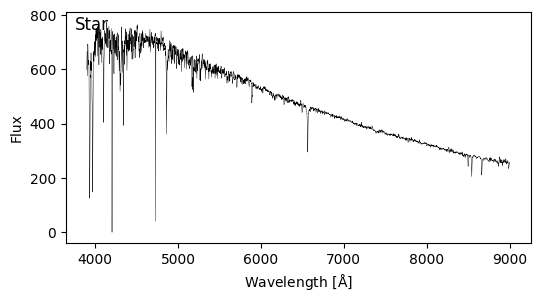

In [15]:
def get_spectrum(file, index):
    with fits.open(file) as hdulist:
        flux = hdulist[0].data[index]
        label = hdulist[1].data['label'][index]
    wavelength = np.linspace(3900, 9000, 3000)
    return wavelength, flux, label

wavelength, flux, label = get_spectrum(file='train_data_01.fits', index=6500)
label_map = {0:'Galaxy', 1:'Quasar', 2:'Star'}

plt.figure(figsize=(6,3), dpi=100)
plt.plot(wavelength, flux, color='black', linewidth=0.3)
plt.text(0.02, 0.92, f'{label_map[label]}', fontsize=12, transform=plt.gca().transAxes)
plt.xlabel('Wavelength [{}]'.format(r'$\mathrm{\AA}$'))
plt.ylabel('Flux')
plt.show()

In [ ]:
def load_fits_data(file_path):
    with fits.open(file_path) as hdulist:
        flux_data = hdulist[0].data
        table_data = hdulist[1].data
        label_list = table_data['label']
        data_array = np.hstack((flux_data, label_list.reshape(-1, 1)))
    return data_array

def spectra_preview(data_array, num_spectra_per_class=2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    wavelength = np.linspace(3900, 9000, 3000)
    label_map = {0: 'Galaxy', 1: 'Quasar', 2: 'Star'}
    for label in [0, 1, 2]:
        class_data = data_array[data_array[:, -1] == label]
        selected_indices = np.random.choice(class_data.shape[0], num_spectra_per_class, replace=False)
        for i, idx in enumerate(selected_indices):
            plt.figure(figsize=(6,3), dpi=100)
            plt.plot(wavelength, class_data[idx, :-1], color='black', linewidth=0.3)
            plt.text(0.02, 0.92, f'{label_map[label]} {i+1}', fontsize=12, transform=plt.gca().transAxes)
            plt.xlabel('Wavelength [{}]'.format(r'$\mathrm{\AA}$'))
            plt.ylabel('Flux')
            plt.tight_layout()
            plt.show()
    return

def energy_normalization(data_array):
    flux, label = data_array[:, :-1], data_array[:, -1]
    l2_norms = np.linalg.norm(flux, axis=1, keepdims=True) + 1e-8
    flux_normalized = flux / l2_norms
    normalized_data_array = np.hstack((flux_normalized, label.reshape(-1, 1)))
    return normalized_data_array

def spectra_smooth(data_array, window_length=10, polyorder=3):
    flux, label = data_array[:, :-1], data_array[:, -1]
    flux_smooth = np.zeros_like(flux)
    for i in range(flux.shape[0]):
        flux_smooth[i] = savgol_filter(flux[i], window_length=window_length, polyorder=polyorder)
    smoothed_data_array = np.hstack((flux_smooth, label.reshape(-1, 1)))
    return smoothed_data_array

In [3]:
def spectra_simulation(data_array, catagary_to_sim, number_to_sim, original_SNR=100):
    flux, label = data_array[:, :-1], data_array[:, -1]
    flux_used = flux[label == catagary_to_sim]
    simulated_data_array = np.empty((number_to_sim, data_array.shape[1]))
    for i in range(number_to_sim): 
        selected_index = np.random.choice(flux_used.shape[0], 1, replace=False)
        flux_selected = flux_used[selected_index][0]
        flux_simulated = flux_selected + np.random.normal(loc=0, 
                                                          scale=np.mean(np.abs(flux_selected)) / original_SNR,
                                                          size=flux_selected.shape)
        flux_simulated = np.append(flux_simulated, catagary_to_sim)
        simulated_data_array[i] = flux_simulated
    return simulated_data_array

In [45]:
def extract_spectral_features(data_array, line_centers, window=3):
    wavelength = np.linspace(3900, 9000, 3000)
    flux = data_array[:, :-1]
    spectral_features = []
    for pos in line_centers:
        indices = np.where((wavelength >= pos - window) & (wavelength <= pos + window))[0]
        feature_flux = np.mean(flux[:, indices], axis=1).reshape(-1, 1)
        spectral_features.append(feature_flux)
    return np.hstack(spectral_features)

def extract_stat_features(data_array, n=50):
    flux = data_array[:, :-1]
    step = math.ceil(flux.shape[1] / n)
    means, vars = np.zeros((flux.shape[0], n)), np.zeros((flux.shape[0], n))
    argmaxs, argmins = np.zeros((flux.shape[0], n)), np.zeros((flux.shape[0], n))
    maxs, mins = np.zeros((flux.shape[0], n)), np.zeros((flux.shape[0], n))
    for i in range(n):
        start = i * step
        stop = min((i + 1) * step, flux.shape[1])
        block = flux[:, start:stop]
        means[:, i], vars[:, i] = np.mean(block, axis=1), np.var(block, axis=1)
        argmaxs[:, i], argmins[:, i] = np.argmax(block, axis=1) + start, np.argmin(block, axis=1) + start
        maxs[:, i], mins[:, i] = np.max(block, axis=1), np.min(block, axis=1)
    return np.hstack((means, vars, argmaxs, argmins, maxs, mins))

In [23]:
original_data_array = load_fits_data('train_data_01.fits')
normalized_data_array = energy_normalization(original_data_array)
smoothed_data_array = spectra_smooth(normalized_data_array, window_length=10, polyorder=3)

counts = [np.sum(original_data_array[:, -1] == i) for i in range(3)]
print(f'Galaxy: {counts[0]} Quasar: {counts[1]} Star: {counts[2]}')

# spectra_preview(original_data_array, num_spectra_per_class=2, random_state=666)

# simulated_data_galaxy = spectra_simulation(normalized_data_array, catagary_to_sim=0, number_to_sim=20)
# simulated_data_quasar = spectra_simulation(normalized_data_array, catagary_to_sim=1, number_to_sim=20)
# simulated_data_star = spectra_simulation(normalized_data_array, catagary_to_sim=2, number_to_sim=20)
# new_data_array = np.vstack((normalized_data_array, simulated_data_galaxy, simulated_data_quasar, simulated_data_star))

Galaxy: 3427 Quasar: 1011 Star: 5562


In [48]:
# extract spectral features: H-alpha, H-beta, H-gamma, H-delta, Mg, Na
line_list = [6562.81, 4861.34, 4340.47, 4101.75, 5183.62, 5889.95]
spectral_features_array = extract_spectral_features(smoothed_data_array, line_list, window=3)

# extract basic statistical features: mean, variance, max, min
stat_features_array = extract_stat_features(smoothed_data_array, n=50)

In [49]:
# PCA
pca_model = PCA(n_components=500, copy=True)
pca_features = pca_model.fit_transform(smoothed_data_array[:, :-1])

In [ ]:
# check PCA results

plt.figure(figsize=(10,3), dpi=100)
label_map = {0: 'Galaxy', 1: 'Quasar', 2: 'Star'}

ax1 = plt.subplot(131)
ax1.plot(np.cumsum(pca_model.explained_variance_ratio_), linewidth=2)
ax1.set_xlabel('Number of PCs')
ax1.set_ylabel('Cumulative Explained Variance')

ax2 = plt.subplot(132)
for label in [0, 1, 2]:
    ax2.scatter(pca_features[smoothed_data_array[:, -1] == label, 0], 
                pca_features[smoothed_data_array[:, -1] == label, 1], 
                label=label_map[label], s=3, edgecolors='None')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.legend(loc='upper right', fontsize=8)

ax3 = plt.subplot(133)
for label in [0, 1, 2]:
    ax3.hist(pca_features[smoothed_data_array[:, -1] == label, 0], 
             bins=50, histtype='step', label=label_map[label])
ax3.set_xlabel('PC1')
ax3.set_ylabel('Number')
ax3.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

In [53]:
# prepare for training
x = pca_features
# x = np.hstack((pca_features, spectral_features_array, stat_features_array))
y = smoothed_data_array[:, -1].astype(int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=30)

In [ ]:
# random forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=30, n_jobs=-1, verbose=1)
rf_model.fit(x_train, y_train)
y_predict_rf = rf_model.predict(x_test)

accuracy_rf = metrics.accuracy_score(y_test, y_predict_rf)
print('Random Forest Accuracy Score: %.3f' % (accuracy_rf))
f1_score_rf = metrics.f1_score(y_test, y_predict_rf, average='macro')
print('Random Forest F1 Score: %.3f' % (f1_score_rf))

confusion_matrix_rf = metrics.confusion_matrix(y_test, y_predict_rf, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix_rf, display_labels=['Galaxy', 'Quasar', 'Star'])
disp.plot(cmap='Blues')
disp.im_.set_clim(vmin=0, vmax=1)
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
# Support Vector Machine
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=30, verbose=True, probability=True)
svm_model.fit(x_train, y_train)
y_predict_svm = svm_model.predict(x_test)

accuracy_svm = metrics.accuracy_score(y_test, y_predict_svm)
print('SVM Accuracy Score: %.3f' % (accuracy_svm))
f1_score_svm = metrics.f1_score(y_test, y_predict_svm, average='macro')
print('SVM F1 Score: %.3f' % (f1_score_svm))

confusion_matrix_svm = metrics.confusion_matrix(y_test, y_predict_svm, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix_svm, display_labels=['Galaxy', 'Quasar', 'Star'])
disp.plot(cmap='Blues')
disp.im_.set_clim(vmin=0, vmax=1)
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.show()

In [ ]:
def CNN_Model_1D(input_shape=500, output_shape=3, conv_branch_num=3, 
                 conv_kernel_size=[3, 5, 7, 9, 11], node_num=[128, 64, 32]):

    # input layer
    input_layer = layers.Input(shape=(input_shape, 1))

    # convolution branches & layers
    convolution_branches = []
    for kernel_size in conv_kernel_size:
        my_layers = input_layer
        for branch_number in range (conv_branch_num):
            my_layers = layers.Conv1D(filters=32,
                                      kernel_size=kernel_size,
                                      strides=1,
                                      padding='same',
                                      activation='relu',
                                      use_bias=False,
                                      )(my_layers)
            my_layers = layers.BatchNormalization()(my_layers)
            my_layers = layers.MaxPool1D(pool_size=3, strides=3)(my_layers)
        convolution_branches.append(my_layers)
    my_layers = layers.concatenate(convolution_branches, axis=-1)
    my_layers = layers.Flatten()(my_layers)

    # fully connected dense layers
    for node_number in node_num:
        my_layers = layers.Dense(units=node_number, activation='relu', use_bias=False)(my_layers)
        my_layers = layers.BatchNormalization()(my_layers)

    # output layer
    my_layers = layers.Dense(units=output_shape, activation='softmax', use_bias=False)(my_layers)

    return models.Model(inputs=input_layer, outputs=my_layers, name='CNN_Model_1D')

In [ ]:
# initialize CNN model
model = CNN_Model_1D(input_shape=x_train.shape[1], output_shape=3, conv_branch_num=3,
                     conv_kernel_size=[3, 5, 7, 9, 11, 13, 15, 17], node_num=[128, 64, 32])

# compile CNN model
model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer = optimizers.Adam(learning_rate=0.0005),
              metrics =['accuracy'])

# plot flow chart
# utils.plot_model(model, to_file='CNN_Model_1D.png', show_shapes=True)

In [ ]:
# train CNN model
batch_size = 128
epochs = 20
training_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
63/63 [==============================] - 20s 232ms/step - loss: 0.2853 - accuracy: 0.9183
Epoch 2/20
63/63 [==============================] - 16s 251ms/step - loss: 0.0942 - accuracy: 0.9744
Epoch 3/20
63/63 [==============================] - 16s 252ms/step - loss: 0.0549 - accuracy: 0.9870
Epoch 4/20
63/63 [==============================] - 18s 278ms/step - loss: 0.0369 - accuracy: 0.9908
Epoch 5/20
63/63 [==============================] - 19s 300ms/step - loss: 0.0185 - accuracy: 0.9966
Epoch 6/20
63/63 [==============================] - 23s 359ms/step - loss: 0.0132 - accuracy: 0.9979
Epoch 7/20
63/63 [==============================] - 22s 356ms/step - loss: 0.0142 - accuracy: 0.9969
Epoch 8/20
63/63 [==============================] - 22s 355ms/step - loss: 0.0106 - accuracy: 0.9979
Epoch 9/20
63/63 [==============================] - 23s 365ms/step - loss: 0.0118 - accuracy: 0.9976
Epoch 10/20
63/63 [==============================] - 23s 371ms/step - loss: 0.0096 - accura

In [ ]:
y_predict_cnn = model.predict(x_test)
y_predict_cnn = np.argmax(y_predict_cnn, axis=1)

accuracy_cnn = metrics.accuracy_score(y_test, y_predict_cnn)
print('CNN Accuracy Score: %.3f' % (accuracy_cnn))
f1_score_cnn = metrics.f1_score(y_test, y_predict_cnn, average='macro')
print('CNN F1 Score: %.3f' % (f1_score_cnn))

confusion_matrix_cnn = metrics.confusion_matrix(y_test, y_predict_cnn, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix_cnn, display_labels=['Galaxy', 'Quasar', 'Star'])
disp.plot(cmap='Blues')
disp.im_.set_clim(vmin=0, vmax=1)
plt.title('Confusion Matrix - CNN')
plt.tight_layout()
plt.show()